In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                        
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('l2_3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(5803, 1, 28) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 532) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.51541478619e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24702486 0.24221157
[0.24221157]
-1 mean score 0.24221157
0.21610429883


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919661  0.009449  0.234983    7  2017-04-16
472     2.507290  2.531222 -0.023932  0.236453    1  2017-04-17
473     2.661330  2.667139 -0.005810  0.252173    2  2017-04-18
474     2.754815  2.735432  0.019383  0.206850    3  2017-04-19
475     2.713762  2.711413  0.002348  0.236495    4  2017-04-20
476     2.999000  2.990916  0.008083  0.157201    5  2017-04-21
477     3.075529  3.077365 -0.001836  0.188575    6  2017-04-22

0.21610429883


pred         y     error    error2  day        date
dayidx                                                         
471     2.919661  2.929110  0.009449  0.234983    7  2017-04-16
472     2.531222  2.507290 -0.023932  0.236453    1  2017-04-17
473     2.667139  2.661330 -0.005810  0.252173    2  2017-04-18
474     2.735432  2.754815  0.019383  0.206850    3  2017-04-19
475     2.711413  2.713762  0.002348  0.236495    4  2017-04-20
476     2.990916  2.999000  0.008083  0.157201    5  2017-04-21
477     3.077365  3.075529 -0.001836  0.188575    6  2017-04-22

(829, 1064)


2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(6632, 1, 28) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 532) (6632,) (6632,)
0.24175857 0.23648688
[0.23648688]
-1 mean score 0.23648688
0.267745763063


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.74786529536e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897600  0.031510  0.244206    7  2017-04-16
472     2.507290  2.468588  0.038703  0.316926    1  2017-04-17
473     2.661330  2.625598  0.035732  0.376676    2  2017-04-18
474     2.754815  2.728923  0.025892  0.252165    3  2017-04-19
475     2.713762  2.696995  0.016767  0.278701    4  2017-04-20
476     2.999000  2.988413  0.010587  0.204298    5  2017-04-21
477     3.075529  3.061832  0.013697  0.201248    6  2017-04-22

0.267745763063


pred         y     error    error2  day        date
dayidx                                                         
471     2.897600  2.929110  0.031510  0.244206    7  2017-04-16
472     2.468588  2.507290  0.038703  0.316926    1  2017-04-17
473     2.625598  2.661330  0.035732  0.376676    2  2017-04-18
474     2.728923  2.754815  0.025892  0.252165    3  2017-04-19
475     2.696995  2.713762  0.016767  0.278701    4  2017-04-20
476     2.988413  2.999000  0.010587  0.204298    5  2017-04-21
477     3.061832  3.075529  0.013697  0.201248    6  2017-04-22

(829, 1064)


3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(7461, 1, 28) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 532) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.08734739163e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24586402 0.24113235
[0.24113235]
-1 mean score 0.24113235
0.289532363415


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899467  0.029643  0.245802    7  2017-04-16
472     2.507290  2.492947  0.014344  0.272838    1  2017-04-17
473     2.661330  2.641347  0.019982  0.421127    2  2017-04-18
474     2.754815  2.750674  0.004141  0.332249    3  2017-04-19
475     2.713762  2.705761  0.008001  0.307318    4  2017-04-20
476     2.999000  3.009901 -0.010901  0.208008    5  2017-04-21
477     3.075529  3.075711 -0.000182  0.239384    6  2017-04-22

0.289532363415


pred         y     error    error2  day        date
dayidx                                                         
471     2.899467  2.929110  0.029643  0.245802    7  2017-04-16
472     2.492947  2.507290  0.014344  0.272838    1  2017-04-17
473     2.641347  2.661330  0.019982  0.421127    2  2017-04-18
474     2.750674  2.754815  0.004141  0.332249    3  2017-04-19
475     2.705761  2.713762  0.008001  0.307318    4  2017-04-20
476     3.009901  2.999000 -0.010901  0.208008    5  2017-04-21
477     3.075711  3.075529 -0.000182  0.239384    6  2017-04-22

(829, 1064)


4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(8290, 1, 28) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 532) (8290,) (8290,)
0.2472905 0.24249817
[0.24249817]
-1 mean score 0.24249817
0.312782764435


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904263  0.024847  0.291852    7  2017-04-16
472     2.507290  2.498721  0.008570  0.256445    1  2017-04-17
473     2.661330  2.610302  0.051027  0.318491    2  2017-04-18
474     2.754815  2.784526 -0.029712  0.421489    3  2017-04-19
475     2.713762  2.677504  0.036258  0.407313    4  2017-04-20
476     2.999000  2.974325  0.024674  0.223036    5  2017-04-21
477     3.075529  3.104713 -0.029184  0.270853    6  2017-04-22

0.312782764435


pred         y     error    error2  day        date
dayidx                                                         
471     2.904263  2.929110  0.024847  0.291852    7  2017-04-16
472     2.498721  2.507290  0.008570  0.256446    1  2017-04-17
473     2.610302  2.661330  0.051027  0.318491    2  2017-04-18
474     2.784526  2.754815 -0.029712  0.421489    3  2017-04-19
475     2.677504  2.713762  0.036258  0.407313    4  2017-04-20
476     2.974325  2.999000  0.024674  0.223036    5  2017-04-21
477     3.104713  3.075529 -0.029184  0.270853    6  2017-04-22

(829, 1064)


5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(9119, 1, 28) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 532) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.78148094834e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24852778 0.24390848
[0.24390848]
-1 mean score 0.24390848
0.343603610992


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.939221 -0.010111  0.364608    7  2017-04-16
472     2.507290  2.504061  0.003230  0.308585    1  2017-04-17
473     2.661330  2.604859  0.056471  0.296084    2  2017-04-18
474     2.754815  2.708788  0.046026  0.287971    3  2017-04-19
475     2.713762  2.727895 -0.014134  0.532259    4  2017-04-20
476     2.999000  2.981664  0.017336  0.333308    5  2017-04-21
477     3.075529  3.086239 -0.010710  0.282410    6  2017-04-22

0.343603551388


pred         y     error    error2  day        date
dayidx                                                         
471     2.939221  2.929110 -0.010112  0.364608    7  2017-04-16
472     2.504061  2.507290  0.003230  0.308585    1  2017-04-17
473     2.604859  2.661330  0.056471  0.296084    2  2017-04-18
474     2.708788  2.754815  0.046026  0.287971    3  2017-04-19
475     2.727895  2.713762 -0.014134  0.532259    4  2017-04-20
476     2.981664  2.999000  0.017336  0.333308    5  2017-04-21
477     3.086239  3.075529 -0.010710  0.282410    6  2017-04-22

(829, 1064)


6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 15.133374
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(9948, 1, 28) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 532) (9948,) (9948,)
0.25111616 0.24369963
[0.24369963]
-1 mean score 0.24369963
0.363113492727


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.03147533517e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.946723 -0.017613  0.368937    7  2017-04-16
472     2.507290  2.494140  0.013151  0.368057    1  2017-04-17
473     2.661330  2.597140  0.064190  0.365470    2  2017-04-18
474     2.754815  2.706424  0.048391  0.260999    3  2017-04-19
475     2.713762  2.704056  0.009706  0.319227    4  2017-04-20
476     2.999000  3.037187 -0.038187  0.413818    5  2017-04-21
477     3.075529  3.160231 -0.084702  0.445286    6  2017-04-22

0.363113492727


pred         y     error    error2  day        date
dayidx                                                         
471     2.946723  2.929110 -0.017613  0.368937    7  2017-04-16
472     2.494140  2.507290  0.013151  0.368057    1  2017-04-17
473     2.597140  2.661330  0.064190  0.365470    2  2017-04-18
474     2.706424  2.754815  0.048391  0.260999    3  2017-04-19
475     2.704056  2.713762  0.009706  0.319227    4  2017-04-20
476     3.037187  2.999000 -0.038187  0.413818    5  2017-04-21
477     3.160231  3.075529 -0.084702  0.445286    6  2017-04-22

(829, 1064)


7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 16.310143
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(10777, 1, 28) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 532) (10777,) (10777,)
0.2482892 0.24188578
[0.24188578]
-1 mean score 0.24188578
0.276872217655


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.26263364883e-12 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905190  0.023920  0.344050    7  2017-04-16
472     2.507290  2.505306  0.001984  0.285740    1  2017-04-17
473     2.661330  2.595870  0.065460  0.356123    2  2017-04-18
474     2.754815  2.709528  0.045287  0.240231    3  2017-04-19
475     2.713762  2.696507  0.017255  0.262940    4  2017-04-20
476     2.999000  2.966069  0.032930  0.200857    5  2017-04-21
477     3.075529  3.110870 -0.035341  0.248165    6  2017-04-22

0.276872217655


pred         y     error    error2  day        date
dayidx                                                         
471     2.905190  2.929110  0.023920  0.344050    7  2017-04-16
472     2.505306  2.507290  0.001984  0.285740    1  2017-04-17
473     2.595870  2.661330  0.065460  0.356123    2  2017-04-18
474     2.709528  2.754815  0.045287  0.240231    3  2017-04-19
475     2.696507  2.713762  0.017254  0.262940    4  2017-04-20
476     2.966069  2.999000  0.032930  0.200857    5  2017-04-21
477     3.110870  3.075529 -0.035341  0.248165    6  2017-04-22

(829, 1064)


8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 17.574337
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(11606, 1, 28) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 532) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.27783243656e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24587421 0.24158055
[0.24158055]
-1 mean score 0.24158055
0.25669708848


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888141  0.040969  0.290082    7  2017-04-16
472     2.507290  2.491335  0.015955  0.292385    1  2017-04-17
473     2.661330  2.620265  0.041065  0.311807    2  2017-04-18
474     2.754815  2.706944  0.047870  0.253339    3  2017-04-19
475     2.713762  2.701547  0.012215  0.262282    4  2017-04-20
476     2.999000  2.963653  0.035347  0.187661    5  2017-04-21
477     3.075529  3.081654 -0.006125  0.199324    6  2017-04-22

0.25669708848


pred         y     error    error2  day        date
dayidx                                                         
471     2.888141  2.929110  0.040969  0.290082    7  2017-04-16
472     2.491335  2.507290  0.015955  0.292385    1  2017-04-17
473     2.620265  2.661330  0.041065  0.311807    2  2017-04-18
474     2.706944  2.754815  0.047870  0.253339    3  2017-04-19
475     2.701547  2.713762  0.012215  0.262282    4  2017-04-20
476     2.963653  2.999000  0.035347  0.187661    5  2017-04-21
477     3.081654  3.075529 -0.006125  0.199324    6  2017-04-22

(829, 1064)


9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 18.806503
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(12435, 1, 28) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 532) (12435,) (12435,)
0.2524579 0.24740843
[0.24740843]
-1 mean score 0.24740843
0.285266250372


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914811  0.014299  0.265930    7  2017-04-16
472     2.507290  2.508057 -0.000767  0.367374    1  2017-04-17
473     2.661330  2.614115  0.047214  0.391901    2  2017-04-18
474     2.754815  2.710680  0.044134  0.286045    3  2017-04-19
475     2.713762  2.709634  0.004128  0.288551    4  2017-04-20
476     2.999000  2.965487  0.033513  0.198853    5  2017-04-21
477     3.075529  3.081153 -0.005624  0.198210    6  2017-04-22

0.285266250372


pred         y     error    error2  day        date
dayidx                                                         
471     2.914811  2.929110  0.014299  0.265930    7  2017-04-16
472     2.508057  2.507290 -0.000767  0.367374    1  2017-04-17
473     2.614115  2.661330  0.047214  0.391901    2  2017-04-18
474     2.710680  2.754815  0.044134  0.286045    3  2017-04-19
475     2.709634  2.713762  0.004128  0.288551    4  2017-04-20
476     2.965487  2.999000  0.033513  0.198853    5  2017-04-21
477     3.081153  3.075529 -0.005624  0.198210    6  2017-04-22

(829, 1064)


10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 19.926521
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(13264, 1, 28) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 532) (13264,) (13264,)
0.25540403 0.25178242
[0.25178242]
-1 mean score 0.25178242
0.325835198164


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.3974590502e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919875  0.009235  0.288922    7  2017-04-16
472     2.507290  2.510379 -0.003088  0.290488    1  2017-04-17
473     2.661330  2.661232  0.000098  0.490771    2  2017-04-18
474     2.754815  2.699168  0.055647  0.386524    3  2017-04-19
475     2.713762  2.705828  0.007934  0.327577    4  2017-04-20
476     2.999000  2.999021 -0.000021  0.251592    5  2017-04-21
477     3.075529  3.110088 -0.034558  0.244973    6  2017-04-22

0.325835198164


pred         y     error    error2  day        date
dayidx                                                         
471     2.919875  2.929110  0.009235  0.288922    7  2017-04-16
472     2.510379  2.507290 -0.003088  0.290488    1  2017-04-17
473     2.661232  2.661330  0.000098  0.490771    2  2017-04-18
474     2.699168  2.754815  0.055647  0.386524    3  2017-04-19
475     2.705828  2.713762  0.007934  0.327577    4  2017-04-20
476     2.999021  2.999000 -0.000021  0.251592    5  2017-04-21
477     3.110088  3.075529 -0.034558  0.244973    6  2017-04-22

(829, 1064)


11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 21.05768
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(14093, 1, 28) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 532) (14093,) (14093,)
0.25659755 0.25287953
[0.25287953]
-1 mean score 0.25287953
0.335144340992


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.90952566259e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928555  0.000556  0.308719    7  2017-04-16
472     2.507290  2.516815 -0.009525  0.296182    1  2017-04-17
473     2.661330  2.646080  0.015250  0.333491    2  2017-04-18
474     2.754815  2.731104  0.023711  0.457421    3  2017-04-19
475     2.713762  2.678400  0.035362  0.404186    4  2017-04-20
476     2.999000  2.982404  0.016596  0.228645    5  2017-04-21
477     3.075529  3.116182 -0.040652  0.317366    6  2017-04-22

0.335144340992


pred         y     error    error2  day        date
dayidx                                                         
471     2.928555  2.929110  0.000556  0.308719    7  2017-04-16
472     2.516815  2.507290 -0.009525  0.296182    1  2017-04-17
473     2.646080  2.661330  0.015250  0.333491    2  2017-04-18
474     2.731104  2.754815  0.023711  0.457421    3  2017-04-19
475     2.678400  2.713762  0.035362  0.404186    4  2017-04-20
476     2.982404  2.999000  0.016596  0.228645    5  2017-04-21
477     3.116182  3.075529 -0.040652  0.317366    6  2017-04-22

(829, 1064)


12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 22.115147
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(14922, 1, 28) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 532) (14922,) (14922,)
0.25787318 0.2548222
[0.2548222]
-1 mean score 0.2548222
0.388402938843


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.55034968838e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.952103 -0.022993  0.394826    7  2017-04-16
472     2.507290  2.518305 -0.011015  0.351444    1  2017-04-17
473     2.661330  2.638990  0.022340  0.334890    2  2017-04-18
474     2.754815  2.698254  0.056560  0.318309    3  2017-04-19
475     2.713762  2.732128 -0.018366  0.612428    4  2017-04-20
476     2.999000  2.984358  0.014642  0.382153    5  2017-04-21
477     3.075529  3.113713 -0.038184  0.324770    6  2017-04-22

0.388402938843


pred         y     error    error2  day        date
dayidx                                                         
471     2.952103  2.929110 -0.022993  0.394826    7  2017-04-16
472     2.518305  2.507290 -0.011015  0.351444    1  2017-04-17
473     2.638990  2.661330  0.022340  0.334890    2  2017-04-18
474     2.698254  2.754815  0.056561  0.318309    3  2017-04-19
475     2.732128  2.713762 -0.018366  0.612428    4  2017-04-20
476     2.984358  2.999000  0.014642  0.382153    5  2017-04-21
477     3.113713  3.075529 -0.038184  0.324770    6  2017-04-22

(829, 1064)


13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 23.15517
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(15751, 1, 28) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 532) (15751,) (15751,)
0.25906378 0.2542856
[0.2542856]
-1 mean score 0.2542856
0.376612514257


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.21569880499e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.960264 -0.031154  0.409140    7  2017-04-16
472     2.507290  2.533532 -0.026241  0.365757    1  2017-04-17
473     2.661330  2.637293  0.024037  0.379676    2  2017-04-18
474     2.754815  2.695833  0.058981  0.284778    3  2017-04-19
475     2.713762  2.710807  0.002954  0.322535    4  2017-04-20
476     2.999000  3.103932 -0.104932  0.464550    5  2017-04-21
477     3.075529  3.121714 -0.046185  0.409852    6  2017-04-22

0.376612484455


pred         y     error    error2  day        date
dayidx                                                         
471     2.960264  2.929110 -0.031154  0.409140    7  2017-04-16
472     2.533532  2.507290 -0.026241  0.365758    1  2017-04-17
473     2.637293  2.661330  0.024037  0.379676    2  2017-04-18
474     2.695833  2.754815  0.058981  0.284778    3  2017-04-19
475     2.710807  2.713762  0.002954  0.322535    4  2017-04-20
476     3.103932  2.999000 -0.104932  0.464550    5  2017-04-21
477     3.121714  3.075529 -0.046185  0.409852    6  2017-04-22

(829, 1064)


14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 24.22639
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(16580, 1, 28) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 532) (16580,) (16580,)
0.25552467 0.25114325
[0.25114325]
-1 mean score 0.25114325
0.283397763968


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.64664973165e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927169  0.001941  0.346602    7  2017-04-16
472     2.507290  2.526452 -0.019161  0.310519    1  2017-04-17
473     2.661330  2.652460  0.008870  0.304591    2  2017-04-18
474     2.754815  2.682015  0.072800  0.284969    3  2017-04-19
475     2.713762  2.703626  0.010136  0.270575    4  2017-04-20
476     2.999000  3.007169 -0.008170  0.194989    5  2017-04-21
477     3.075529  3.071153  0.004376  0.271539    6  2017-04-22

0.283397763968


pred         y     error    error2  day        date
dayidx                                                         
471     2.927169  2.929110  0.001941  0.346602    7  2017-04-16
472     2.526452  2.507290 -0.019161  0.310519    1  2017-04-17
473     2.652460  2.661330  0.008870  0.304591    2  2017-04-18
474     2.682015  2.754815  0.072800  0.284969    3  2017-04-19
475     2.703626  2.713762  0.010136  0.270575    4  2017-04-20
476     3.007169  2.999000 -0.008169  0.194989    5  2017-04-21
477     3.071153  3.075529  0.004376  0.271539    6  2017-04-22

(829, 1064)


15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 25.357664
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(17409, 1, 28) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 532) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.09248502342e-12 / 5.96046447754e-08
  RuntimeWarning)


0.25215825 0.24929857
[0.24929857]
-1 mean score 0.24929857
0.277268797159


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903997  0.025113  0.313507    7  2017-04-16
472     2.507290  2.492425  0.014866  0.326799    1  2017-04-17
473     2.661330  2.639959  0.021371  0.337903    2  2017-04-18
474     2.754815  2.676416  0.078399  0.263396    3  2017-04-19
475     2.713762  2.703257  0.010504  0.303491    4  2017-04-20
476     2.999000  3.002219 -0.003219  0.189193    5  2017-04-21
477     3.075529  3.057615  0.017914  0.206592    6  2017-04-22

0.277268797159


pred         y     error    error2  day        date
dayidx                                                         
471     2.903997  2.929110  0.025113  0.313507    7  2017-04-16
472     2.492425  2.507290  0.014866  0.326799    1  2017-04-17
473     2.639959  2.661330  0.021371  0.337903    2  2017-04-18
474     2.676416  2.754815  0.078399  0.263396    3  2017-04-19
475     2.703257  2.713762  0.010504  0.303491    4  2017-04-20
476     3.002219  2.999000 -0.003219  0.189193    5  2017-04-21
477     3.057615  3.075529  0.017914  0.206592    6  2017-04-22

(829, 1064)


16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 26.465925
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(18238, 1, 28) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 532) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.76757895715e-11 / 5.96046447754e-08
  RuntimeWarning)


0.25911212 0.25571603
[0.25571603]
-1 mean score 0.25571603
0.303749859333


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918374  0.010736  0.278265    7  2017-04-16
472     2.507290  2.537680 -0.030390  0.385186    1  2017-04-17
473     2.661330  2.604985  0.056345  0.417946    2  2017-04-18
474     2.754815  2.668476  0.086339  0.317017    3  2017-04-19
475     2.713762  2.709880  0.003882  0.286521    4  2017-04-20
476     2.999000  2.993755  0.005244  0.230025    5  2017-04-21
477     3.075529  3.061650  0.013880  0.211289    6  2017-04-22

0.303749829531


pred         y     error    error2  day        date
dayidx                                                         
471     2.918375  2.929110  0.010736  0.278265    7  2017-04-16
472     2.537680  2.507290 -0.030390  0.385186    1  2017-04-17
473     2.604985  2.661330  0.056345  0.417946    2  2017-04-18
474     2.668476  2.754815  0.086339  0.317017    3  2017-04-19
475     2.709880  2.713762  0.003882  0.286521    4  2017-04-20
476     2.993755  2.999000  0.005244  0.230025    5  2017-04-21
477     3.061650  3.075529  0.013880  0.211289    6  2017-04-22

(829, 1064)


17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 27.605818
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(19067, 1, 28) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 532) (19067,) (19067,)
0.2616379 0.2583522
[0.2583522]
-1 mean score 0.2583522
0.303479015827


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.3309682897e-12 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921556  0.007555  0.287051    7  2017-04-16
472     2.507290  2.522434 -0.015143  0.299436    1  2017-04-17
473     2.661330  2.647682  0.013648  0.436285    2  2017-04-18
474     2.754815  2.661359  0.093455  0.337111    3  2017-04-19
475     2.713762  2.696050  0.017712  0.301125    4  2017-04-20
476     2.999000  3.019590 -0.020590  0.225550    5  2017-04-21
477     3.075529  3.067285  0.008244  0.237796    6  2017-04-22

0.303479015827


pred         y     error    error2  day        date
dayidx                                                         
471     2.921556  2.929110  0.007554  0.287051    7  2017-04-16
472     2.522434  2.507290 -0.015143  0.299436    1  2017-04-17
473     2.647682  2.661330  0.013648  0.436285    2  2017-04-18
474     2.661359  2.754815  0.093455  0.337111    3  2017-04-19
475     2.696050  2.713762  0.017712  0.301125    4  2017-04-20
476     3.019590  2.999000 -0.020590  0.225550    5  2017-04-21
477     3.067285  3.075529  0.008244  0.237796    6  2017-04-22

(829, 1064)


18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 28.75126
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(19896, 1, 28) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 532) (19896,) (19896,)
0.26224056 0.2604433
[0.2604433]
-1 mean score 0.2604433
0.301603764296


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922465  0.006645  0.301207    7  2017-04-16
472     2.507290  2.529635 -0.022344  0.271058    1  2017-04-17
473     2.661330  2.627449  0.033881  0.321836    2  2017-04-18
474     2.754815  2.704530  0.050284  0.365839    3  2017-04-19
475     2.713762  2.664691  0.049070  0.367077    4  2017-04-20
476     2.999000  3.013544 -0.014544  0.246326    5  2017-04-21
477     3.075529  3.083353 -0.007824  0.237884    6  2017-04-22

0.301603764296


pred         y     error    error2  day        date
dayidx                                                         
471     2.922465  2.929110  0.006645  0.301207    7  2017-04-16
472     2.529635  2.507290 -0.022344  0.271058    1  2017-04-17
473     2.627449  2.661330  0.033881  0.321836    2  2017-04-18
474     2.704530  2.754815  0.050284  0.365839    3  2017-04-19
475     2.664691  2.713762  0.049070  0.367077    4  2017-04-20
476     3.013544  2.999000 -0.014544  0.246326    5  2017-04-21
477     3.083353  3.075529 -0.007824  0.237884    6  2017-04-22

(829, 1064)


19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 29.798643
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(20725, 1, 28) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 532) (20725,) (20725,)
0.26184607 0.2613055
[0.2613055]
-1 mean score 0.2613055
0.323969215155


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.31411695362e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.959449 -0.030339  0.358512    7  2017-04-16
472     2.507290  2.517564 -0.010273  0.320310    1  2017-04-17
473     2.661330  2.614928  0.046402  0.314717    2  2017-04-18
474     2.754815  2.686542  0.068273  0.284565    3  2017-04-19
475     2.713762  2.716216 -0.002455  0.430524    4  2017-04-20
476     2.999000  3.006266 -0.007266  0.282925    5  2017-04-21
477     3.075529  3.092292 -0.016763  0.276232    6  2017-04-22

0.323969185352


pred         y     error    error2  day        date
dayidx                                                         
471     2.959449  2.929110 -0.030339  0.358512    7  2017-04-16
472     2.517564  2.507290 -0.010273  0.320310    1  2017-04-17
473     2.614928  2.661330  0.046402  0.314717    2  2017-04-18
474     2.686542  2.754815  0.068273  0.284565    3  2017-04-19
475     2.716216  2.713762 -0.002455  0.430524    4  2017-04-20
476     3.006266  2.999000 -0.007266  0.282925    5  2017-04-21
477     3.092292  3.075529 -0.016763  0.276232    6  2017-04-22

(829, 1064)


20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 30.796307
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(21554, 1, 28) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 532) (21554,) (21554,)
0.264252 0.26161557
[0.26161557]
-1 mean score 0.26161557
0.344036370516


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.74802541833e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.993669 -0.064559  0.381519    7  2017-04-16
472     2.507290  2.521847 -0.014557  0.381347    1  2017-04-17
473     2.661330  2.607209  0.054121  0.355938    2  2017-04-18
474     2.754815  2.687534  0.067281  0.274207    3  2017-04-19
475     2.713762  2.703265  0.010497  0.320660    4  2017-04-20
476     2.999000  3.059501 -0.060502  0.346254    5  2017-04-21
477     3.075529  3.123278 -0.047749  0.348330    6  2017-04-22

0.344036310911


pred         y     error    error2  day        date
dayidx                                                         
471     2.993669  2.929110 -0.064559  0.381519    7  2017-04-16
472     2.521847  2.507290 -0.014557  0.381347    1  2017-04-17
473     2.607209  2.661330  0.054121  0.355938    2  2017-04-18
474     2.687534  2.754815  0.067281  0.274207    3  2017-04-19
475     2.703265  2.713762  0.010497  0.320660    4  2017-04-20
476     3.059501  2.999000 -0.060502  0.346254    5  2017-04-21
477     3.123278  3.075529 -0.047749  0.348330    6  2017-04-22

(829, 1064)


21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 31.792852
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(22383, 1, 28) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 532) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.26514727114e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26056203 0.25775656
[0.25775656]
-1 mean score 0.25775656
0.307354450226


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905506  0.023604  0.381367    7  2017-04-16
472     2.507290  2.524581 -0.017290  0.294060    1  2017-04-17
473     2.661330  2.604910  0.056420  0.361310    2  2017-04-18
474     2.754815  2.667222  0.087593  0.314254    3  2017-04-19
475     2.713762  2.673291  0.040470  0.310704    4  2017-04-20
476     2.999000  2.960887  0.038113  0.206080    5  2017-04-21
477     3.075529  3.102852 -0.027323  0.283706    6  2017-04-22

0.307354450226


pred         y     error    error2  day        date
dayidx                                                         
471     2.905506  2.929110  0.023604  0.381367    7  2017-04-16
472     2.524581  2.507290 -0.017290  0.294060    1  2017-04-17
473     2.604909  2.661330  0.056420  0.361310    2  2017-04-18
474     2.667222  2.754815  0.087593  0.314254    3  2017-04-19
475     2.673291  2.713762  0.040470  0.310704    4  2017-04-20
476     2.960887  2.999000  0.038113  0.206080    5  2017-04-21
477     3.102852  3.075529 -0.027323  0.283706    6  2017-04-22

(829, 1064)


22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 32.870983
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(23212, 1, 28) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 532) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.85094178768e-11 / 5.96046447754e-08
  RuntimeWarning)


0.25673294 0.25547272
[0.25547272]
-1 mean score 0.25547272
0.295630991459


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.860051  0.069059  0.340632    7  2017-04-16
472     2.507290  2.469176  0.038115  0.327339    1  2017-04-17
473     2.661330  2.618686  0.042643  0.329187    2  2017-04-18
474     2.754815  2.664392  0.090423  0.321186    3  2017-04-19
475     2.713762  2.656644  0.057118  0.331200    4  2017-04-20
476     2.999000  2.950418  0.048582  0.209135    5  2017-04-21
477     3.075529  3.054519  0.021010  0.210738    6  2017-04-22

0.295631021261


pred         y     error    error2  day        date
dayidx                                                         
471     2.860050  2.929110  0.069059  0.340632    7  2017-04-16
472     2.469176  2.507290  0.038115  0.327339    1  2017-04-17
473     2.618686  2.661330  0.042644  0.329187    2  2017-04-18
474     2.664392  2.754815  0.090423  0.321186    3  2017-04-19
475     2.656644  2.713762  0.057118  0.331200    4  2017-04-20
476     2.950418  2.999000  0.048582  0.209135    5  2017-04-21
477     3.054519  3.075529  0.021011  0.210738    6  2017-04-22

(829, 1064)


23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 33.974537
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(24041, 1, 28) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 532) (24041,) (24041,)
0.26264304 0.26301405
[0.26301405]
-1 mean score 0.26301405
0.355428010225


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.79449066454e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899604  0.029506  0.296359    7  2017-04-16
472     2.507290  2.324769  0.182521  0.567177    1  2017-04-17
473     2.661330  2.582641  0.078689  0.454912    2  2017-04-18
474     2.754815  2.684305  0.070510  0.308837    3  2017-04-19
475     2.713762  2.670737  0.043024  0.397156    4  2017-04-20
476     2.999000  2.954375  0.044625  0.230520    5  2017-04-21
477     3.075529  3.063356  0.012173  0.233034    6  2017-04-22

0.355428010225


pred         y     error    error2  day        date
dayidx                                                         
471     2.899604  2.929110  0.029506  0.296360    7  2017-04-16
472     2.324769  2.507290  0.182521  0.567177    1  2017-04-17
473     2.582641  2.661330  0.078689  0.454912    2  2017-04-18
474     2.684305  2.754815  0.070510  0.308837    3  2017-04-19
475     2.670737  2.713762  0.043024  0.397156    4  2017-04-20
476     2.954375  2.999000  0.044625  0.230520    5  2017-04-21
477     3.063356  3.075529  0.012173  0.233034    6  2017-04-22

(829, 1064)


24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 35.208443
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(24870, 1, 28) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 532) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.70008945757e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2648205 0.2636574
[0.2636574]
-1 mean score 0.2636574
0.365226119757


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904747  0.024363  0.317893    7  2017-04-16
472     2.507290  2.482584  0.024707  0.324165    1  2017-04-17
473     2.661330  2.600239  0.061091  0.554070    2  2017-04-18
474     2.754815  2.650377  0.104438  0.473966    3  2017-04-19
475     2.713762  2.692528  0.021234  0.340183    4  2017-04-20
476     2.999000  2.977310  0.021689  0.272576    5  2017-04-21
477     3.075529  3.072857  0.002673  0.273729    6  2017-04-22

0.365226119757


pred         y     error    error2  day        date
dayidx                                                         
471     2.904747  2.929110  0.024363  0.317893    7  2017-04-16
472     2.482584  2.507290  0.024706  0.324165    1  2017-04-17
473     2.600239  2.661330  0.061091  0.554070    2  2017-04-18
474     2.650377  2.754815  0.104438  0.473966    3  2017-04-19
475     2.692528  2.713762  0.021234  0.340183    4  2017-04-20
476     2.977310  2.999000  0.021689  0.272576    5  2017-04-21
477     3.072857  3.075529  0.002672  0.273729    6  2017-04-22

(829, 1064)


25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 36.335064
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(25699, 1, 28) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 532) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.56298446408e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26597974 0.26621643
[0.26621643]
-1 mean score 0.26621643
0.38870459795


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916419  0.012691  0.364984    7  2017-04-16
472     2.507290  2.470517  0.036773  0.346272    1  2017-04-17
473     2.661330  2.627320  0.034009  0.342902    2  2017-04-18
474     2.754815  2.662442  0.092373  0.546714    3  2017-04-19
475     2.713762  2.582223  0.131539  0.544107    4  2017-04-20
476     2.999000  2.994726  0.004273  0.268137    5  2017-04-21
477     3.075529  3.105000 -0.029470  0.307817    6  2017-04-22

0.38870459795


pred         y     error    error2  day        date
dayidx                                                         
471     2.916419  2.929110  0.012691  0.364984    7  2017-04-16
472     2.470517  2.507290  0.036773  0.346272    1  2017-04-17
473     2.627320  2.661330  0.034009  0.342902    2  2017-04-18
474     2.662442  2.754815  0.092373  0.546714    3  2017-04-19
475     2.582223  2.713762  0.131539  0.544107    4  2017-04-20
476     2.994726  2.999000  0.004273  0.268137    5  2017-04-21
477     3.105000  3.075529 -0.029470  0.307817    6  2017-04-22

(829, 1064)


26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 37.374123
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(26528, 1, 28) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 532) (26528,) (26528,)
0.2664984 0.26756692
[0.26756692]
-1 mean score 0.26756692
0.376665920019


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.90016839069e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936538 -0.007428  0.405486    7  2017-04-16
472     2.507290  2.466327  0.040963  0.397373    1  2017-04-17
473     2.661330  2.612076  0.049254  0.362410    2  2017-04-18
474     2.754815  2.699378  0.055437  0.313178    3  2017-04-19
475     2.713762  2.583091  0.130671  0.571341    4  2017-04-20
476     2.999000  2.970281  0.028718  0.320749    5  2017-04-21
477     3.075529  3.112246 -0.036717  0.266125    6  2017-04-22

0.376665920019


pred         y     error    error2  day        date
dayidx                                                         
471     2.936538  2.929110 -0.007428  0.405486    7  2017-04-16
472     2.466327  2.507290  0.040963  0.397373    1  2017-04-17
473     2.612076  2.661330  0.049254  0.362410    2  2017-04-18
474     2.699378  2.754815  0.055437  0.313178    3  2017-04-19
475     2.583091  2.713762  0.130671  0.571341    4  2017-04-20
476     2.970281  2.999000  0.028718  0.320749    5  2017-04-21
477     3.112246  3.075529 -0.036717  0.266125    6  2017-04-22

(829, 1064)


27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 38.450596
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(27357, 1, 28) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 532) (27357,) (27357,)
0.26787725 0.26632538
[0.26632538]
-1 mean score 0.26632538
0.38468298316


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.29564666287e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938007 -0.008897  0.452619    7  2017-04-16
472     2.507290  2.486603  0.020688  0.421688    1  2017-04-17
473     2.661330  2.609009  0.052321  0.399252    2  2017-04-18
474     2.754815  2.701996  0.052818  0.290416    3  2017-04-19
475     2.713762  2.675618  0.038143  0.328435    4  2017-04-20
476     2.999000  2.991420  0.007580  0.408316    5  2017-04-21
477     3.075529  3.102707 -0.027178  0.392055    6  2017-04-22

0.38468298316


pred         y     error    error2  day        date
dayidx                                                         
471     2.938007  2.929110 -0.008897  0.452619    7  2017-04-16
472     2.486603  2.507290  0.020688  0.421688    1  2017-04-17
473     2.609009  2.661330  0.052321  0.399252    2  2017-04-18
474     2.701996  2.754815  0.052819  0.290416    3  2017-04-19
475     2.675618  2.713762  0.038143  0.328435    4  2017-04-20
476     2.991420  2.999000  0.007580  0.408316    5  2017-04-21
477     3.102707  3.075529 -0.027178  0.392055    6  2017-04-22

(829, 1064)


28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 39.47981
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(28186, 1, 28) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 532) (28186,) (28186,)
0.2640236 0.26173878
[0.26173878]
-1 mean score 0.26173878
0.381193935871


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.09106948108e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.829434  0.099676  0.527243    7  2017-04-16
472     2.507290  2.430108  0.077183  0.442188    1  2017-04-17
473     2.661330  2.598155  0.063174  0.422228    2  2017-04-18
474     2.754815  2.690259  0.064556  0.337912    3  2017-04-19
475     2.713762  2.659227  0.054535  0.343934    4  2017-04-20
476     2.999000  2.973539  0.025461  0.240318    5  2017-04-21
477     3.075529  3.077638 -0.002109  0.354535    6  2017-04-22

0.381193935871


pred         y     error    error2  day        date
dayidx                                                         
471     2.829434  2.929110  0.099676  0.527243    7  2017-04-16
472     2.430108  2.507290  0.077183  0.442188    1  2017-04-17
473     2.598155  2.661330  0.063174  0.422228    2  2017-04-18
474     2.690259  2.754815  0.064556  0.337912    3  2017-04-19
475     2.659227  2.713762  0.054535  0.343934    4  2017-04-20
476     2.973539  2.999000  0.025461  0.240318    5  2017-04-21
477     3.077638  3.075529 -0.002109  0.354535    6  2017-04-22

(829, 1064)


29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 40.793427
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(29015, 1, 28) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 532) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.80413025869e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2599155 0.2605563
[0.2605563]
-1 mean score 0.2605563
0.397035986185


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.843474  0.085636  0.385008    7  2017-04-16
472     2.507290  2.309781  0.197510  0.671444    1  2017-04-17
473     2.661330  2.549456  0.111874  0.493433    2  2017-04-18
474     2.754815  2.656756  0.098058  0.382190    3  2017-04-19
475     2.713762  2.640395  0.073366  0.376519    4  2017-04-20
476     2.999000  2.976259  0.022741  0.225795    5  2017-04-21
477     3.075529  3.048234  0.027296  0.244862    6  2017-04-22

0.397035986185


pred         y     error    error2  day        date
dayidx                                                         
471     2.843474  2.929110  0.085636  0.385008    7  2017-04-16
472     2.309781  2.507290  0.197510  0.671444    1  2017-04-17
473     2.549456  2.661330  0.111874  0.493433    2  2017-04-18
474     2.656756  2.754815  0.098058  0.382190    3  2017-04-19
475     2.640395  2.713762  0.073366  0.376519    4  2017-04-20
476     2.976259  2.999000  0.022741  0.225795    5  2017-04-21
477     3.048234  3.075529  0.027296  0.244862    6  2017-04-22

(829, 1064)


30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 41.98585
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(29844, 1, 28) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 532) (29844,) (29844,)
0.2664857 0.26589045
[0.26589045]
-1 mean score 0.26589045
0.376234024763


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.79313316867e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895673  0.033437  0.284702    7  2017-04-16
472     2.507290  2.426077  0.081213  0.488401    1  2017-04-17
473     2.661330  2.517850  0.143480  0.600177    2  2017-04-18
474     2.754815  2.659302  0.095513  0.407500    3  2017-04-19
475     2.713762  2.656065  0.057697  0.378105    4  2017-04-20
476     2.999000  2.977570  0.021430  0.246745    5  2017-04-21
477     3.075529  3.071028  0.004501  0.228009    6  2017-04-22

0.376234024763


pred         y     error    error2  day        date
dayidx                                                         
471     2.895673  2.929110  0.033437  0.284702    7  2017-04-16
472     2.426077  2.507290  0.081213  0.488401    1  2017-04-17
473     2.517849  2.661330  0.143480  0.600177    2  2017-04-18
474     2.659302  2.754815  0.095513  0.407499    3  2017-04-19
475     2.656065  2.713762  0.057697  0.378105    4  2017-04-20
476     2.977570  2.999000  0.021430  0.246745    5  2017-04-21
477     3.071028  3.075529  0.004501  0.228009    6  2017-04-22

(829, 1064)


31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 43.22814
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(30673, 1, 28) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 532) (30673,) (30673,)
0.2693338 0.26905683
[0.26905683]
-1 mean score 0.26905683
0.38817769289


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.25242453697e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899382  0.029728  0.309725    7  2017-04-16
472     2.507290  2.483205  0.024085  0.333296    1  2017-04-17
473     2.661330  2.573473  0.087857  0.503671    2  2017-04-18
474     2.754815  2.660687  0.094127  0.540495    3  2017-04-19
475     2.713762  2.586628  0.127134  0.476548    4  2017-04-20
476     2.999000  2.981916  0.017083  0.270556    5  2017-04-21
477     3.075529  3.071318  0.004211  0.282953    6  2017-04-22

0.38817769289


pred         y     error    error2  day        date
dayidx                                                         
471     2.899382  2.929110  0.029728  0.309725    7  2017-04-16
472     2.483205  2.507290  0.024085  0.333296    1  2017-04-17
473     2.573473  2.661330  0.087857  0.503671    2  2017-04-18
474     2.660687  2.754815  0.094127  0.540495    3  2017-04-19
475     2.586628  2.713762  0.127134  0.476548    4  2017-04-20
476     2.981916  2.999000  0.017083  0.270556    5  2017-04-21
477     3.071318  3.075529  0.004211  0.282953    6  2017-04-22

(829, 1064)


32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 44.446426
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(31502, 1, 28) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 532) (31502,) (31502,)
0.2700806 0.2698304
[0.2698304]
-1 mean score 0.2698304
0.41444593668


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.88355398587e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908977  0.020133  0.384262    7  2017-04-16
472     2.507290  2.508168 -0.000878  0.296976    1  2017-04-17
473     2.661330  2.609149  0.052181  0.395847    2  2017-04-18
474     2.754815  2.705228  0.049587  0.493068    3  2017-04-19
475     2.713762  2.557813  0.155948  0.670094    4  2017-04-20
476     2.999000  2.951227  0.047772  0.348349    5  2017-04-21
477     3.075529  3.075569 -0.000039  0.312526    6  2017-04-22

0.41444593668


pred         y     error    error2  day        date
dayidx                                                         
471     2.908977  2.929110  0.020133  0.384262    7  2017-04-16
472     2.508168  2.507290 -0.000878  0.296976    1  2017-04-17
473     2.609149  2.661330  0.052181  0.395847    2  2017-04-18
474     2.705228  2.754815  0.049587  0.493068    3  2017-04-19
475     2.557813  2.713762  0.155948  0.670094    4  2017-04-20
476     2.951227  2.999000  0.047772  0.348349    5  2017-04-21
477     3.075569  3.075529 -0.000039  0.312526    6  2017-04-22

(829, 1064)


33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 45.511513
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(32331, 1, 28) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 532) (32331,) (32331,)
0.271205 0.2712518
[0.2712518]
-1 mean score 0.2712518
0.414070814848


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.78670177212e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927052  0.002058  0.395821    7  2017-04-16
472     2.507290  2.483896  0.023394  0.362645    1  2017-04-17
473     2.661330  2.624189  0.037140  0.334237    2  2017-04-18
474     2.754815  2.707319  0.047496  0.338762    3  2017-04-19
475     2.713762  2.660063  0.053698  0.553962    4  2017-04-20
476     2.999000  2.926641  0.072359  0.521294    5  2017-04-21
477     3.075529  3.085959 -0.010430  0.391776    6  2017-04-22

0.414070814848


pred         y     error    error2  day        date
dayidx                                                         
471     2.927052  2.929110  0.002058  0.395821    7  2017-04-16
472     2.483896  2.507290  0.023394  0.362645    1  2017-04-17
473     2.624189  2.661330  0.037140  0.334237    2  2017-04-18
474     2.707319  2.754815  0.047496  0.338762    3  2017-04-19
475     2.660063  2.713762  0.053698  0.553962    4  2017-04-20
476     2.926641  2.999000  0.072359  0.521294    5  2017-04-21
477     3.085959  3.075529 -0.010430  0.391776    6  2017-04-22

(829, 1064)


34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 46.568817
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(33160, 1, 28) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 532) (33160,) (33160,)
0.27226207 0.26987007
[0.26987007]
-1 mean score 0.26987007
0.401883661747


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.02337979441e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929313 -0.000203  0.406670    7  2017-04-16
472     2.507290  2.515559 -0.008268  0.374942    1  2017-04-17
473     2.661330  2.634034  0.027296  0.417364    2  2017-04-18
474     2.754815  2.706015  0.048800  0.306955    3  2017-04-19
475     2.713762  2.679883  0.033879  0.376919    4  2017-04-20
476     2.999000  2.980883  0.018117  0.420667    5  2017-04-21
477     3.075529  3.025681  0.049849  0.509668    6  2017-04-22

0.401883631945


pred         y     error    error2  day        date
dayidx                                                         
471     2.929313  2.929110 -0.000203  0.406670    7  2017-04-16
472     2.515559  2.507290 -0.008268  0.374942    1  2017-04-17
473     2.634034  2.661330  0.027296  0.417364    2  2017-04-18
474     2.706015  2.754815  0.048800  0.306955    3  2017-04-19
475     2.679883  2.713762  0.033879  0.376919    4  2017-04-20
476     2.980883  2.999000  0.018117  0.420667    5  2017-04-21
477     3.025681  3.075529  0.049849  0.509668    6  2017-04-22

(829, 1064)


35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 47.473278
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(33989, 1, 28) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 532) (33989,) (33989,)
0.26817036 0.26678854
[0.26678854]
-1 mean score 0.26678854
0.323838144541


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.32021138413e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878986  0.050124  0.415862    7  2017-04-16
472     2.507290  2.503646  0.003645  0.315847    1  2017-04-17
473     2.661330  2.626666  0.034664  0.367201    2  2017-04-18
474     2.754815  2.715750  0.039065  0.314609    3  2017-04-19
475     2.713762  2.675224  0.038538  0.308792    4  2017-04-20
476     2.999000  2.947427  0.051573  0.239074    5  2017-04-21
477     3.075529  3.044734  0.030796  0.305482    6  2017-04-22

0.323838144541


pred         y     error    error2  day        date
dayidx                                                         
471     2.878985  2.929110  0.050124  0.415862    7  2017-04-16
472     2.503646  2.507290  0.003645  0.315847    1  2017-04-17
473     2.626666  2.661330  0.034664  0.367201    2  2017-04-18
474     2.715750  2.754815  0.039065  0.314609    3  2017-04-19
475     2.675224  2.713762  0.038538  0.308792    4  2017-04-20
476     2.947427  2.999000  0.051573  0.239074    5  2017-04-21
477     3.044734  3.075529  0.030795  0.305482    6  2017-04-22

(829, 1064)


36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 48.749073
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(34818, 1, 28) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 532) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.17765014091e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26411217 0.26388198
[0.26388198]
-1 mean score 0.26388198
0.320397764444


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.825954  0.103156  0.395742    7  2017-04-16
472     2.507290  2.472685  0.034606  0.363594    1  2017-04-17
473     2.661330  2.619780  0.041550  0.368639    2  2017-04-18
474     2.754815  2.696499  0.058316  0.284516    3  2017-04-19
475     2.713762  2.664886  0.048876  0.355382    4  2017-04-20
476     2.999000  2.946802  0.052198  0.211885    5  2017-04-21
477     3.075529  3.041674  0.033855  0.263027    6  2017-04-22

0.320397764444


pred         y     error    error2  day        date
dayidx                                                         
471     2.825954  2.929110  0.103156  0.395742    7  2017-04-16
472     2.472685  2.507290  0.034606  0.363594    1  2017-04-17
473     2.619780  2.661330  0.041550  0.368639    2  2017-04-18
474     2.696499  2.754815  0.058316  0.284516    3  2017-04-19
475     2.664886  2.713762  0.048876  0.355382    4  2017-04-20
476     2.946802  2.999000  0.052198  0.211885    5  2017-04-21
477     3.041674  3.075529  0.033855  0.263027    6  2017-04-22

(829, 1064)


37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 49.87967
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(35647, 1, 28) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 532) (35647,) (35647,)
0.27000815 0.26940012
[0.26940012]
-1 mean score 0.26940012
0.339174479246


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.78817628707e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893156  0.035954  0.285226    7  2017-04-16
472     2.507290  2.456228  0.051063  0.465323    1  2017-04-17
473     2.661330  2.606385  0.054944  0.450330    2  2017-04-18
474     2.754815  2.710520  0.044295  0.315171    3  2017-04-19
475     2.713762  2.689171  0.024591  0.341745    4  2017-04-20
476     2.999000  2.932844  0.066156  0.260243    5  2017-04-21
477     3.075529  3.064187  0.011343  0.256183    6  2017-04-22

0.339174479246


pred         y     error    error2  day        date
dayidx                                                         
471     2.893156  2.929110  0.035954  0.285226    7  2017-04-16
472     2.456228  2.507290  0.051063  0.465323    1  2017-04-17
473     2.606385  2.661330  0.054944  0.450330    2  2017-04-18
474     2.710520  2.754815  0.044295  0.315171    3  2017-04-19
475     2.689171  2.713762  0.024591  0.341745    4  2017-04-20
476     2.932844  2.999000  0.066156  0.260243    5  2017-04-21
477     3.064187  3.075529  0.011343  0.256183    6  2017-04-22

(829, 1064)


38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 51.08654
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(36476, 1, 28) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 532) (36476,) (36476,)
0.27282092 0.27345535
[0.27345535]
-1 mean score 0.27345535
0.367732912302


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.58359088132e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894219  0.034891  0.334632    7  2017-04-16
472     2.507290  2.529625 -0.022335  0.307176    1  2017-04-17
473     2.661330  2.614662  0.046667  0.532928    2  2017-04-18
474     2.754815  2.689948  0.064867  0.429095    3  2017-04-19
475     2.713762  2.660052  0.053709  0.388874    4  2017-04-20
476     2.999000  2.973650  0.025349  0.284838    5  2017-04-21
477     3.075529  3.063796  0.011734  0.296589    6  2017-04-22

0.367732912302


pred         y     error    error2  day        date
dayidx                                                         
471     2.894219  2.929110  0.034891  0.334632    7  2017-04-16
472     2.529625  2.507290 -0.022335  0.307176    1  2017-04-17
473     2.614662  2.661330  0.046667  0.532928    2  2017-04-18
474     2.689948  2.754815  0.064867  0.429095    3  2017-04-19
475     2.660052  2.713762  0.053709  0.388874    4  2017-04-20
476     2.973650  2.999000  0.025349  0.284838    5  2017-04-21
477     3.063796  3.075529  0.011734  0.296589    6  2017-04-22

(829, 1064)


39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 52.0488
(829, 517, 28)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 532) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 532) (50169,) (50169,)
(37305, 1, 28) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 532) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.1264502072e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2736246 0.27382135
[0.27382135]
-1 mean score 0.27382135
0.373593658209


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910116  0.018994  0.377805    7  2017-04-16
472     2.507290  2.510218 -0.002928  0.316680    1  2017-04-17
473     2.661330  2.648798  0.012532  0.344652    2  2017-04-18
474     2.754815  2.753435  0.001380  0.500626    3  2017-04-19
475     2.713762  2.646851  0.066911  0.478749    4  2017-04-20
476     2.999000  2.960909  0.038091  0.266011    5  2017-04-21
477     3.075529  3.087154 -0.011625  0.330632    6  2017-04-22

0.373593658209


pred         y     error    error2  day        date
dayidx                                                         
471     2.910116  2.929110  0.018994  0.377805    7  2017-04-16
472     2.510218  2.507290 -0.002928  0.316680    1  2017-04-17
473     2.648798  2.661330  0.012532  0.344652    2  2017-04-18
474     2.753435  2.754815  0.001380  0.500626    3  2017-04-19
475     2.646851  2.713762  0.066911  0.478749    4  2017-04-20
476     2.960909  2.999000  0.038091  0.266011    5  2017-04-21
477     3.087154  3.075529 -0.011625  0.330632    6  2017-04-22

(829, 1064)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

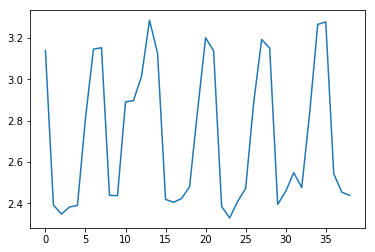

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.730310   
air_0164b9927d20bcc3_2017-04-23              1.284583   
air_0241aa3964b7f861_2017-04-23              2.316731   
air_0328696196e46f18_2017-04-23              2.163399   
air_034a3d5b40d5b1b1_2017-04-23              3.485503   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.642404  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.613163  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.142462  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.700661  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.638840

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l2_3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')